# $\Phi$-SO demo

## Packages import

In [1]:
# External packages
import torch
import numpy as np

# Pyplot
import matplotlib.pyplot as plt

# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import checks

/opt/homebrew/anaconda3/envs/PhySO/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.

default get_start_method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs :  8
Recommended config {'parallel_mode': False, 'n_cpus': 8}
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo fro

/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/execute.py:180: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:214: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [2]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cpu


In [3]:
torch.cuda.is_available()

False

In [4]:
# Seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

## Test case

#### Data points

In [5]:
data_size = int(1e3)

In [6]:
# Data points
m1 = np.random.uniform(1, 5, data_size) # kg
m2 = np.random.uniform(1, 5, data_size) # kg
r = np.random.uniform(1, 5, data_size) # m
X_array = np.stack((m1, m2, r), axis=0)

# Target constants
G  = 6.123 # m3 kg-1 s-2

# Normalize by
norm = 1.#/5

y_array = (m1*m2*G/(r**2))*norm # kg.m.s-2

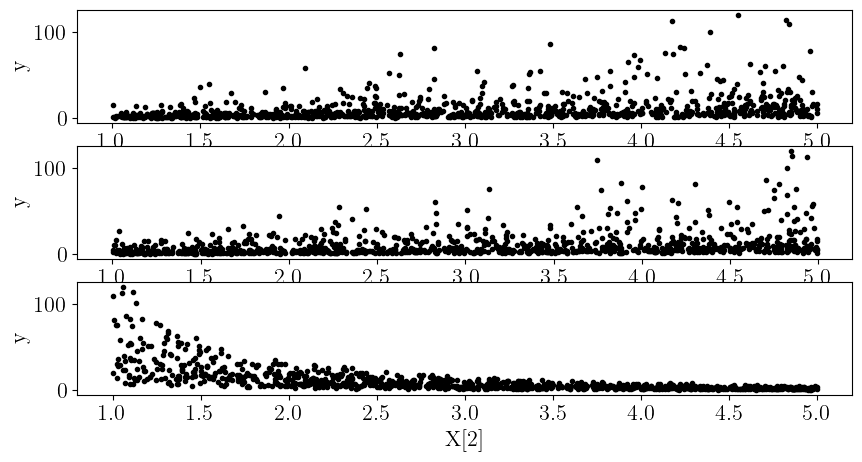

In [7]:
n_dim = X_array.shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,5))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(X_array[i], y_array, 'k.',)
    curr_ax.set_xlabel("X[%i]"%(i))
    curr_ax.set_ylabel("y")
plt.show()

#### Sending data to device

In [8]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(X_array).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(y_array).to(DEVICE)

# ------ Constants ------
const1 = torch.tensor(np.array(1.)).to(DEVICE)

## Run config

### Library config

In [9]:
# Choosing a [length, time, mass] convention for this run
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"m1" : 0          , "m2" : 1         , "r" : 2           , },
                "input_var_units"      : {"m1" : [0, 0, 1]  , "m2" : [0, 0, 1] , "r" : [1, 0, 0] , },
                "input_var_complexity" : {"m1" : 1.         , "m2" : 1.        , "r" : 1.          , },
                # constants
                #"constants"            : {"1" : const1          , },
                #"constants_units"      : {"1" : [0, 0, 0, 0, 0] , },
                #"constants_complexity" : {"1" : 1.              , },
                # free constants
                "free_constants"            : {"Cm1"              , "Cm2"              , "Cr"              , "CF"               , },
                "free_constants_init_val"   : {"Cm1" : 1.         , "Cm2" : 1.         , "Cr" : 1.         , "CF" : 1.          , },
                "free_constants_units"      : {"Cm1" : [0, 0, 1]  , "Cm2" : [0, 0, 1]  , "Cr" : [1, 0, 0]  , "CF" : [1, -2, 1]  , },
                "free_constants_complexity" : {"Cm1" : 1.         , "Cm2" : 1.         , "Cr" : 1.         , "CF" : 1.          , },
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [1, -2, 1],
                  "superparent_name"  : "F",
                }

### Learning config

In [10]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, # PHYSICALITY
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                 "parallel_mode" : True,
                 "n_cpus"        : None,
                }

In [11]:
BATCH_SIZE = int(1e4)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [12]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e9),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.

default get_start_method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs :  8
Recommended config {'parallel_mode': False, 'n_cpus': 8}


/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/execute.py:180: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
/Users/wtenachi/Documents/ASTRO_research/projects/AI_physicist/my_AI_physicist/PhySO/PhySO/physo/physym/reward.py:214: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


### Free constant optimizer config

In [13]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 15,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

### Priors config

In [14]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 4, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 12, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                ("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                ("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedFunctions", {"functions":["cos","sin", "log", "exp",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

### Cell config

In [15]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

### Logger

In [16]:
save_path_training_curves = 'demo_curves.png'
save_path_log             = 'demo.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log,
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 5,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

### Run config

In [17]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

## Dummy epoch for prior tuning

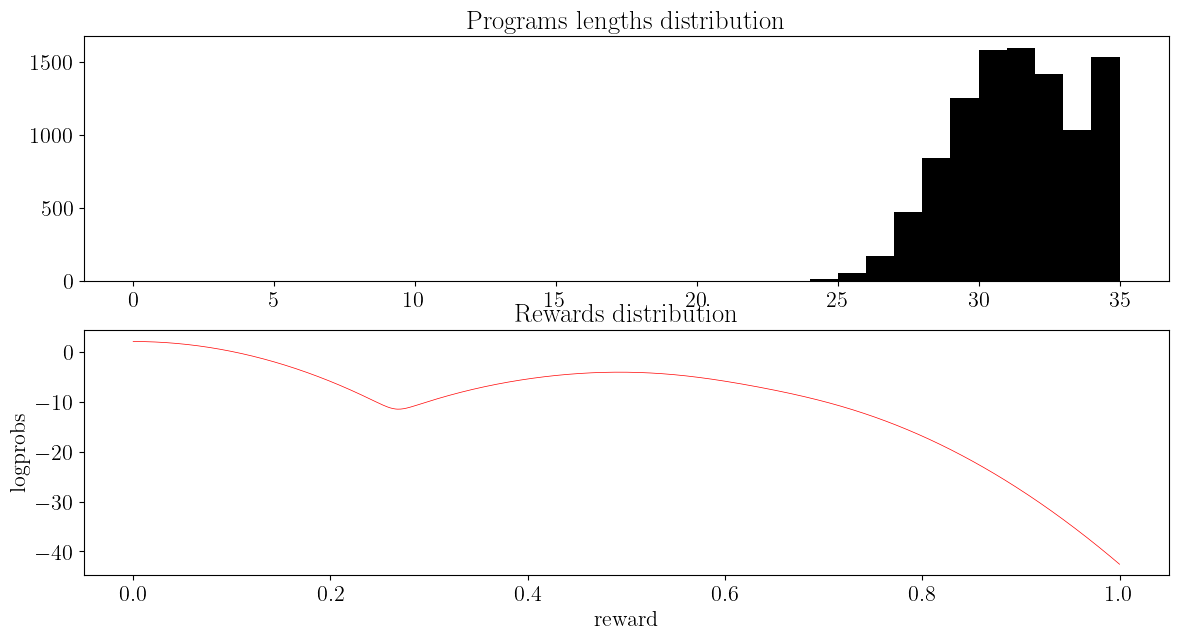

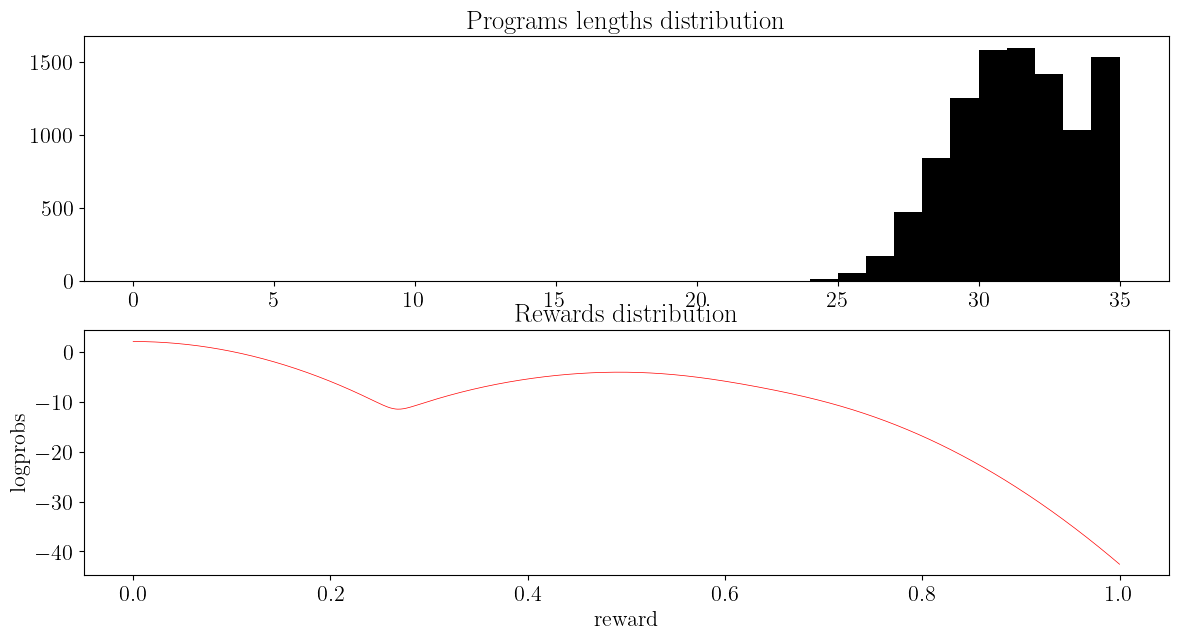

In [18]:
checks.dummy_epoch_SR(X = X, y = y, run_config = run_config)

## Run

=========== Epoch 00000 ===========
-> Time 5.01 s

Overall best  at R=0.551575
-> Raw expression : 
               r               
───────────────────────────────
                              2
⎛              0.5           ⎞ 
⎜          ⎛r ⎞              ⎟ 
⎜          ⎜──⎟              ⎟ 
⎜          ⎝CF⎠              ⎟ 
⎜────────────────────────────⎟ 
⎜   ⎛                    0.5⎞⎟ 
⎜   ⎜⎛             Cm₁⋅r⎞   ⎟⎟ 
⎜   ⎜⎜       Cm₁ + ─────⎟   ⎟⎟ 
⎜   ⎜⎜  r            r  ⎟   ⎟⎟ 
⎜sin⎜⎜- ── + ───────────⎟   ⎟⎟ 
⎝   ⎝⎝  Cr       Cm₁    ⎠   ⎠⎠ 

Best of epoch at R=0.551575
-> Raw expression : 
               r               
───────────────────────────────
                              2
⎛              0.5           ⎞ 
⎜          ⎛r ⎞              ⎟ 
⎜          ⎜──⎟              ⎟ 
⎜          ⎝CF⎠              ⎟ 
⎜────────────────────────────⎟ 
⎜   ⎛                    0.5⎞⎟ 
⎜   ⎜⎛             Cm₁⋅r⎞   ⎟⎟ 
⎜   ⎜⎜       Cm₁ + ─────⎟   ⎟⎟ 
⎜   ⎜⎜  r            r  ⎟   ⎟⎟ 
⎜sin⎜⎜- ── + ────

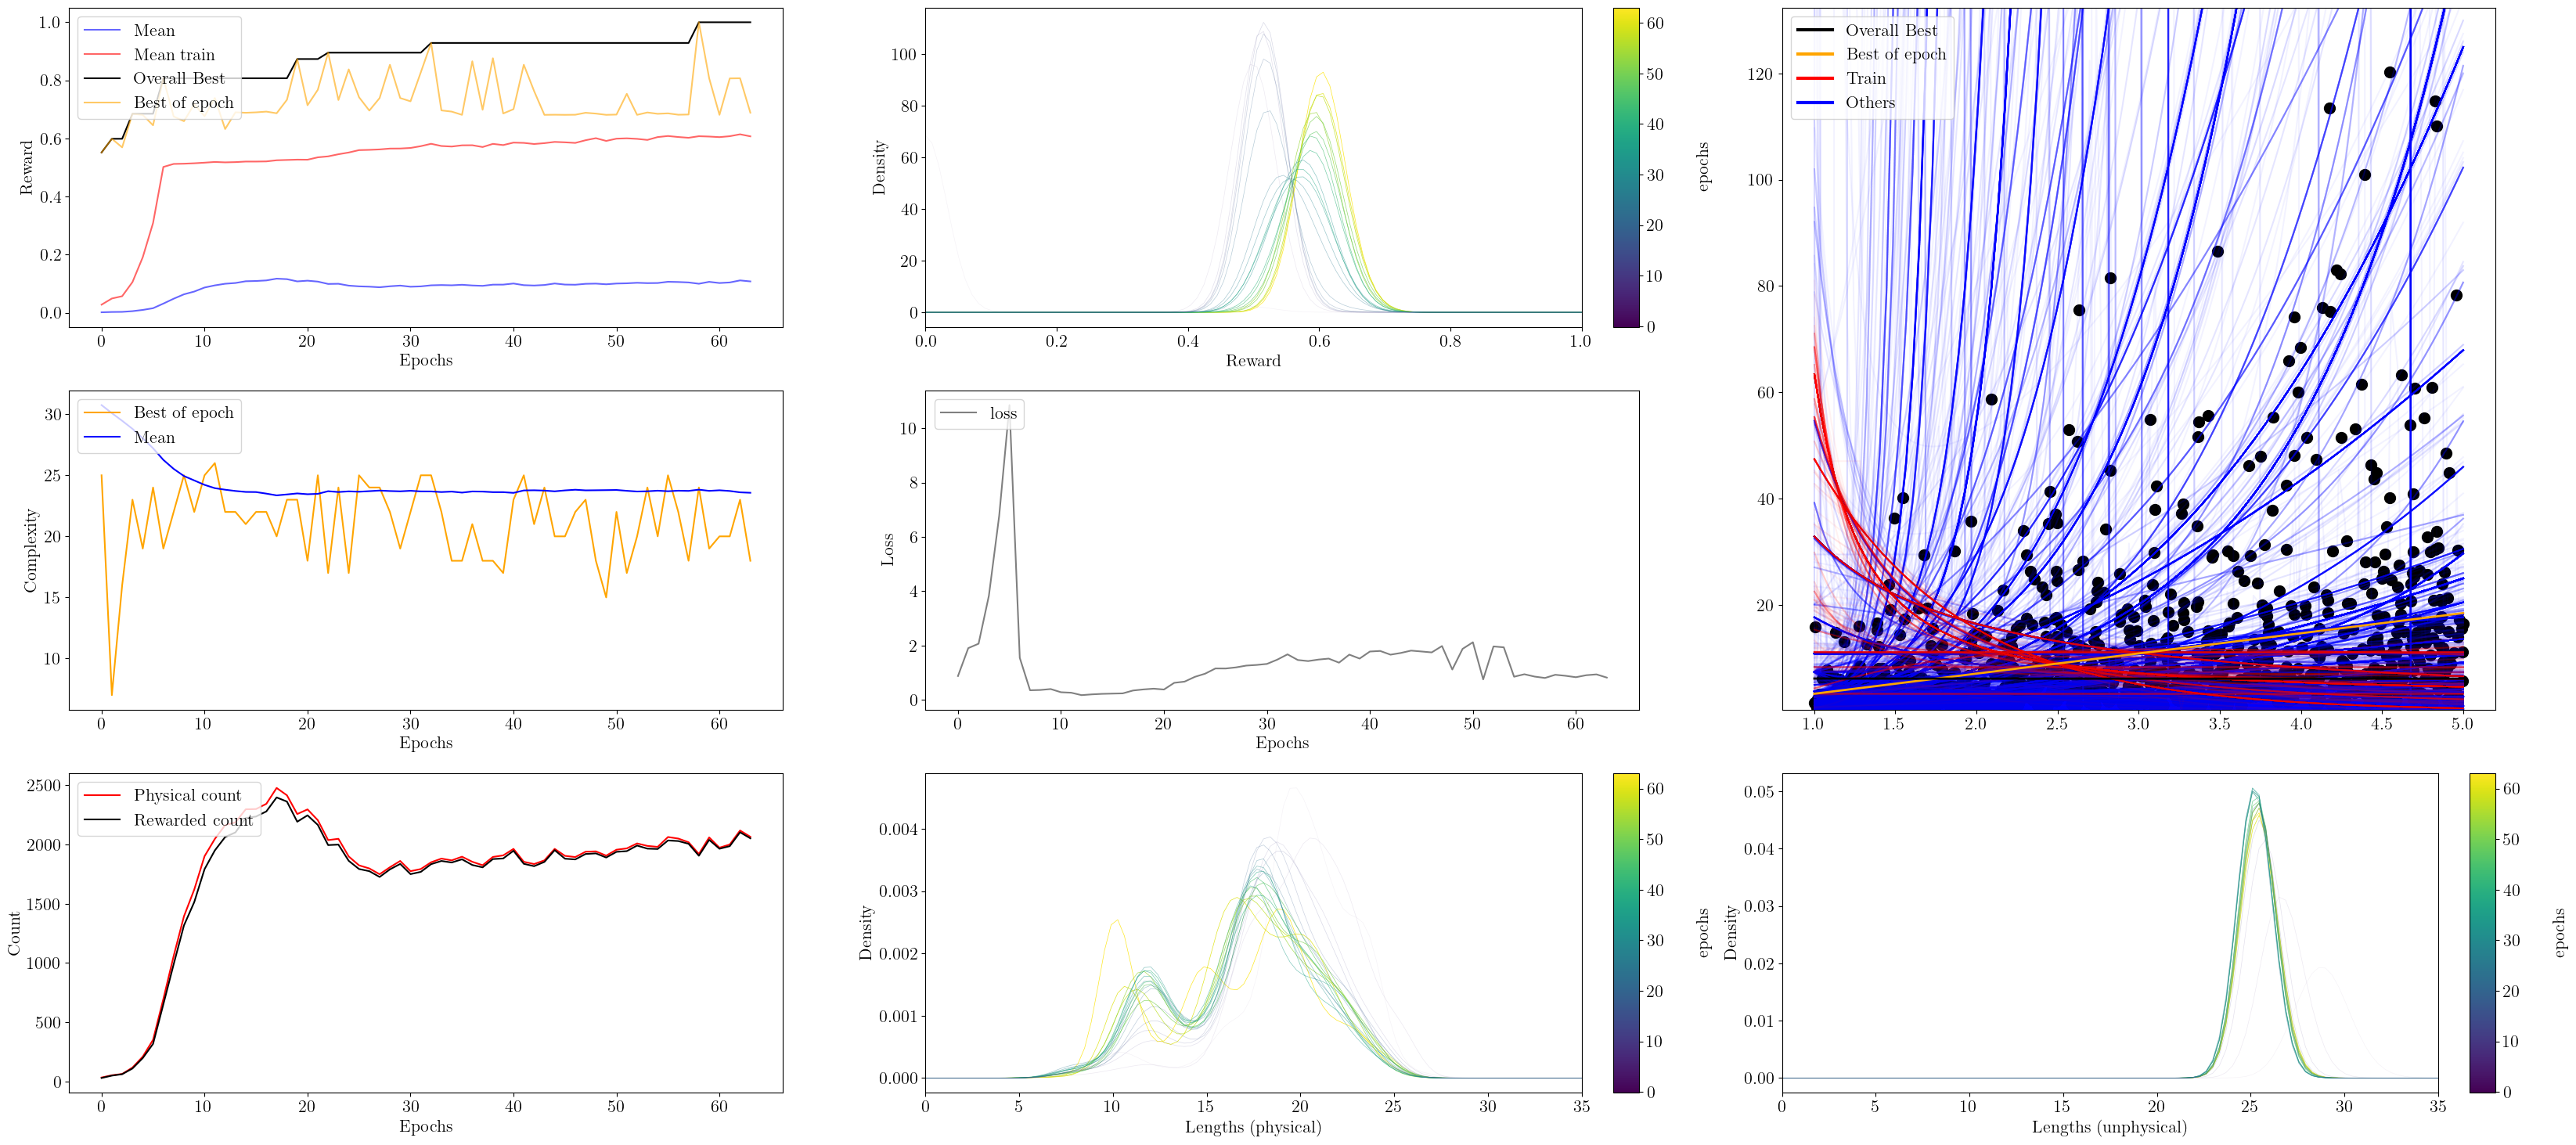

In [19]:
rewards, candidates = physo.fit ([X,], [y,], run_config,
                                stop_reward = 0.9999,
                                stop_after_n_epochs = 5)

## Results

### Run plot

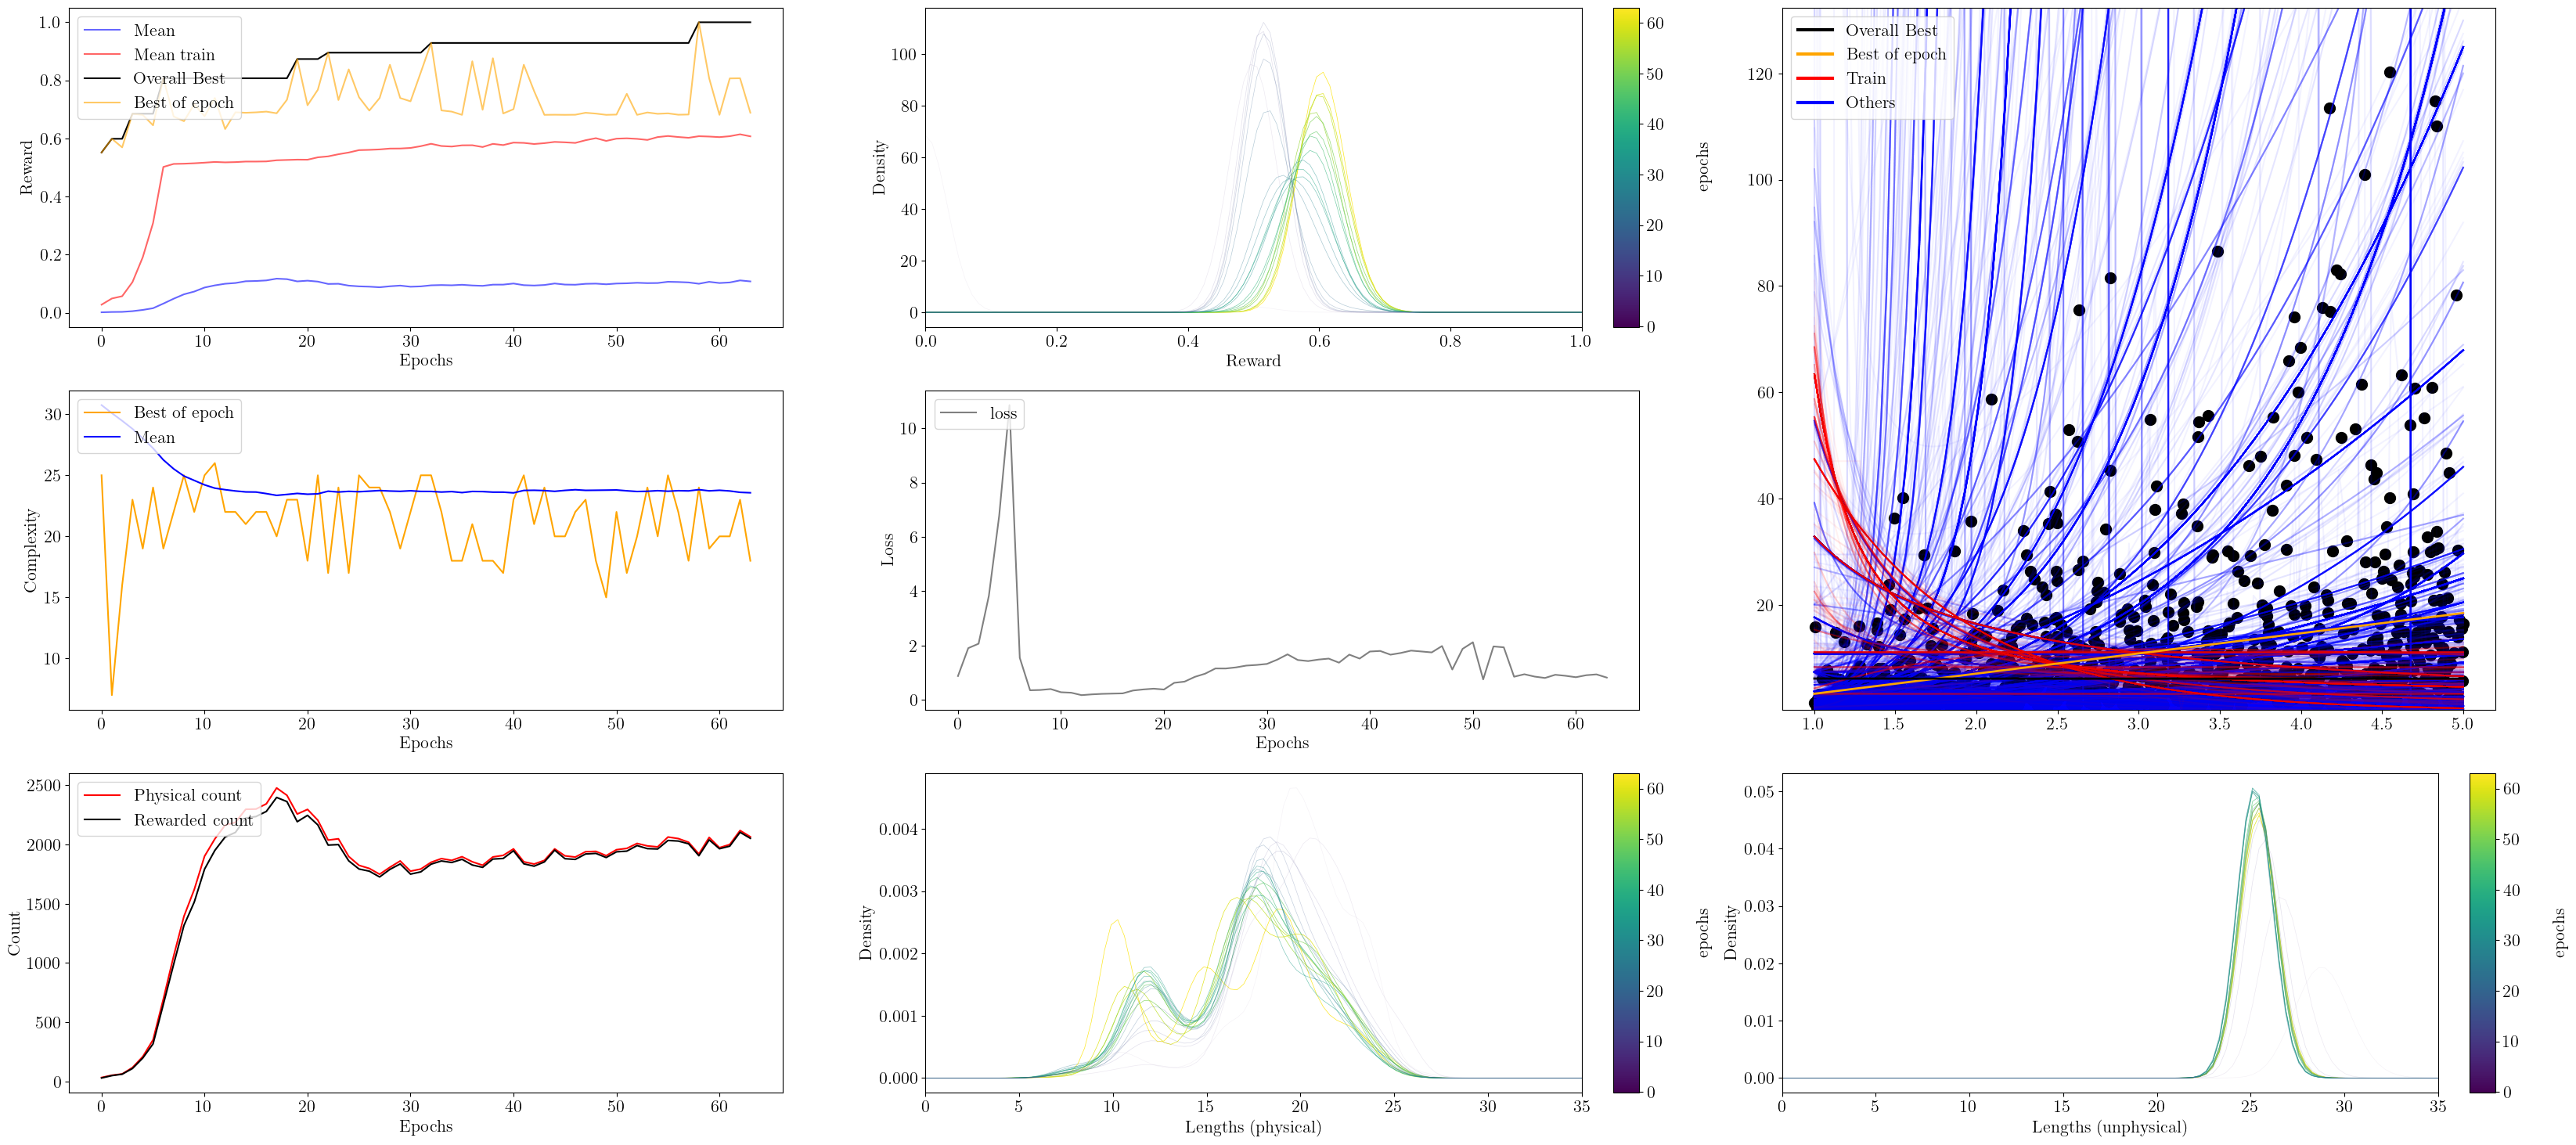

In [20]:
run_visualiser.make_visualisation()
run_visualiser.save_visualisation()
run_visualiser.save_data()

### Pareto Front

In [21]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = pareto_front_rmse
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("RMSE")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin), 
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)

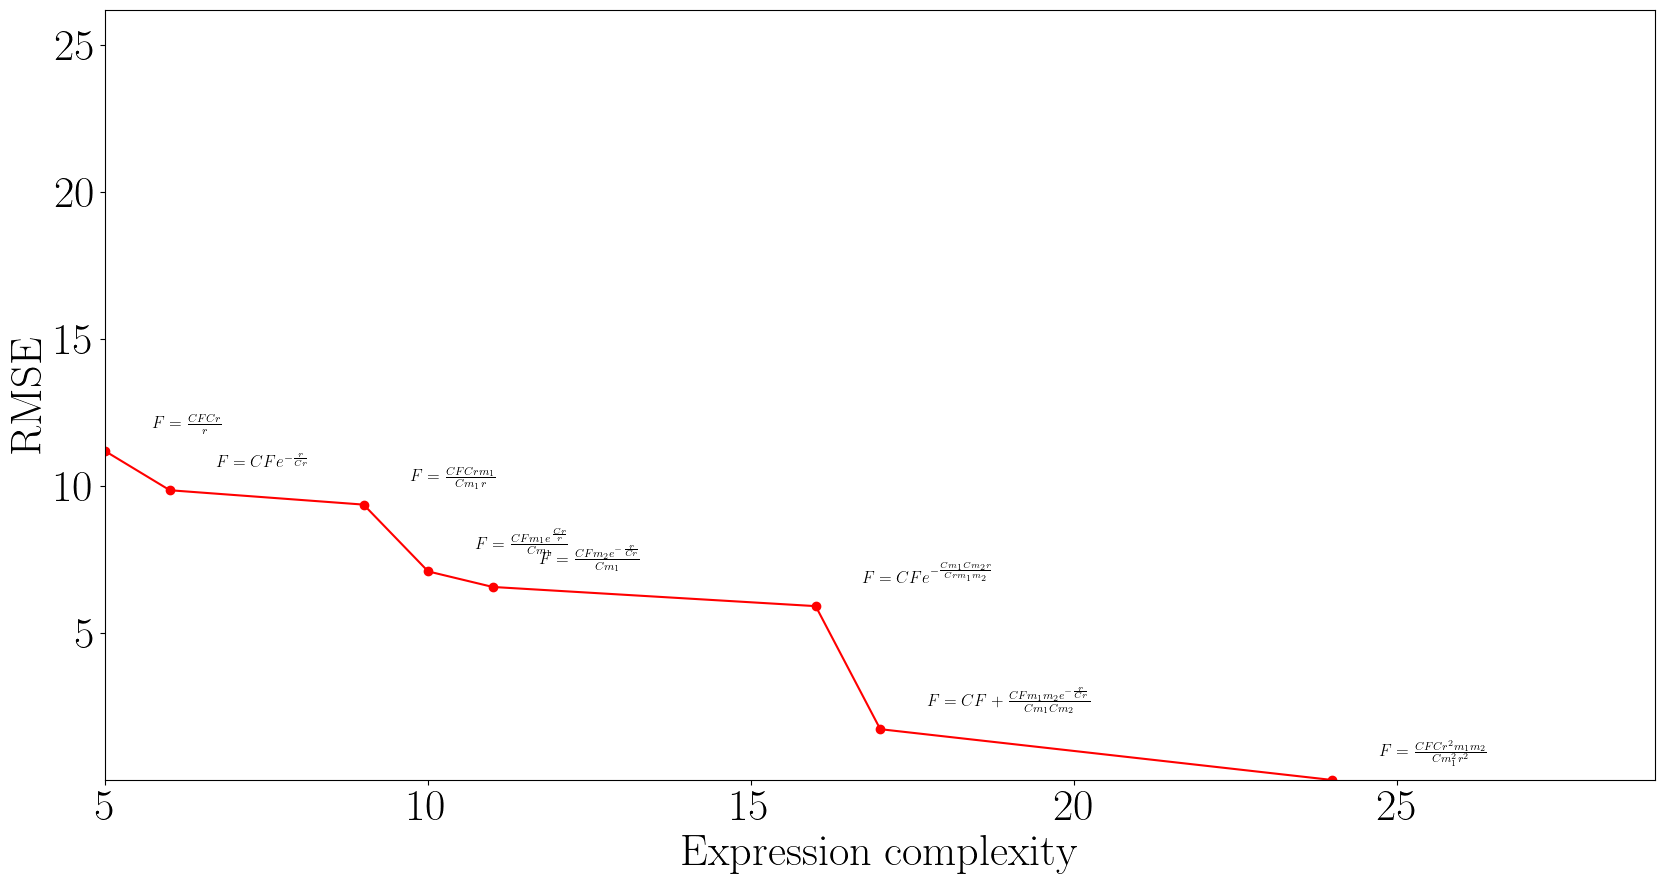

In [22]:
plot_pareto_front(run_logger)


### Complexity - accuracy optimums

In [23]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()


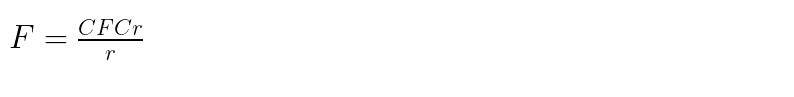

CF = 5.734812
Cm1 = 1.000000
Cm2 = 1.000000
Cr = 5.734812


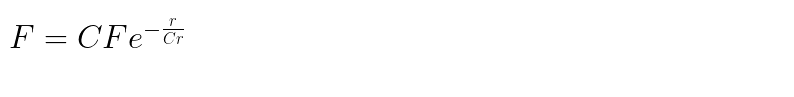

CF = 145.253684
Cm1 = 1.000000
Cm2 = 1.000000
Cr = 0.893619


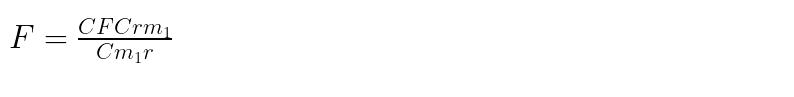

CF = 1.728883
Cm1 = 0.269769
Cm2 = 1.000000
Cr = 1.728883


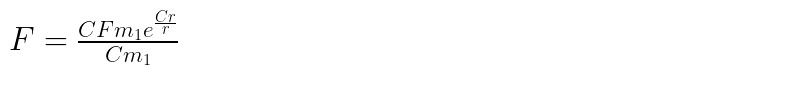

CF = 0.525221
Cm1 = 0.703770
Cm2 = 1.000000
Cr = 3.404944


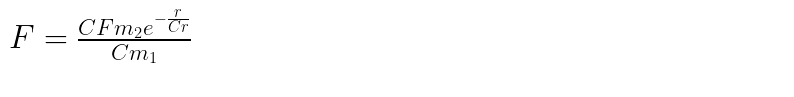

CF = 1.301956
Cm1 = 0.023382
Cm2 = 1.000000
Cr = 0.840386


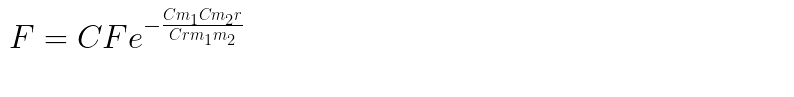

CF = 167.808515
Cm1 = 7.962882
Cm2 = 7.962882
Cr = 4.874293


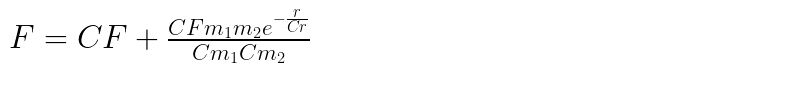

CF = 1.884441
Cm1 = 0.308391
Cm2 = 0.308391
Cr = 0.765418


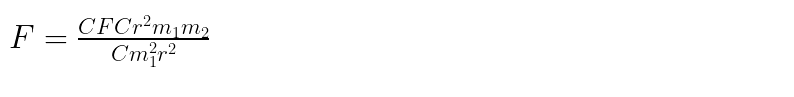

CF = 1.195315
Cm1 = 0.614762
Cm2 = 1.000000
Cr = 1.391388


In [24]:
for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    free_consts = prog.free_consts.class_values[0].detach().cpu().numpy()
    for i in range (len(free_consts)):
        print("%s = %f"%(prog.library.free_const_names[i], free_consts[i]))